In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 20,
})
np.random.seed(0)

In [18]:
# Load data from MNIST dataset (please uncompress data.zip)
# in csv format (Kaggle) 
# https://www.kaggle.com/oddrationale/mnist-in-csv/home
# First column = Label
# Other columns = Image
df_train = pd.read_csv('data/mnist_train.csv', header=None, index_col=None)
df_test  = pd.read_csv('data/mnist_test.csv',  header=None, index_col=None)

# Reduce size (to reduce size computations)
df_train = df_train.iloc[:2000]
df_test  = df_test.iloc[:2000]

# Split data in X and y
X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_test,  y_test  = df_test.iloc[:,  1:], df_test.iloc[:, 0]

n = len(X_train.columns)

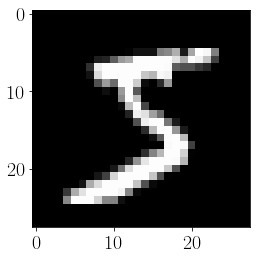

In [19]:
# Example image
x_i = X_train.iloc[0].to_numpy().reshape(-1, 28)
plt.imshow(x_i, cmap='gray')

## Try to distinguish some digit from the others

In [20]:
# Classify for some integer
TrainingInteger = 5

# The training data set
X0_train = X_train.to_numpy()
y0_train = (y_train == TrainingInteger).astype(int).to_numpy()  #converts to 0/1
y0_train[y0_train == 0] = -1                                    #tag the non-zeros as -1

# The testing data set
X0_test = X_test.to_numpy()
y0_test =  (y_test == TrainingInteger).astype(int).to_numpy()
y0_test[y0_test == 0] = -1

m_train = len(y0_train)
m_test  = len(y0_test)

In [21]:
# Define cvxpy problem
a = cp.Variable(n)
b = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(y0_train, X0_train @ a + b)))/m_train
reg = cp.norm(a, 1)
lam = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(loss + lam * reg))

In [22]:
def predict(X, a, b):
    theValue = X @ a + b
    theSign   = np.sign(theValue)
    return theSign

In [23]:
# Compute a trade-off curve and record train and test error.
n_trials = 40 # try more steps (it might take 15 min)
train_error = np.zeros(n_trials)
test_error = np.zeros(n_trials)
lambda_vals = np.logspace(-2, 1, n_trials)

for i in tqdm(range(n_trials)):
    lam.value = lambda_vals[i]
    problem.solve()
    
    y0_train_pred  = predict(X0_train, a.value, b.value)
    y0_test_pred   = predict(X0_test, a.value, b.value)
    train_error[i] = (y0_train != y0_train_pred).sum()/m_train
    test_error[i]  = (y0_test != y0_test_pred).sum()/m_test

100%|██████████| 40/40 [02:00<00:00,  3.02s/it]


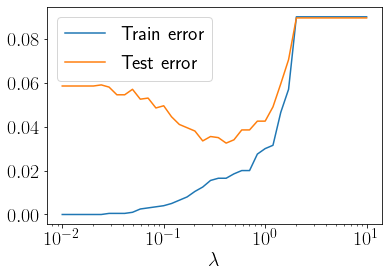

In [25]:
# Plot the train and test error over the trade-off curve.
plt.figure()
plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$")
plt.show()

In [33]:
#run it one more time with the best lambda value
lam.value = lambda_vals[np.argmin(train_error)]
problem.solve()
y0_test_pred   = predict(X0_test, a.value, b.value)

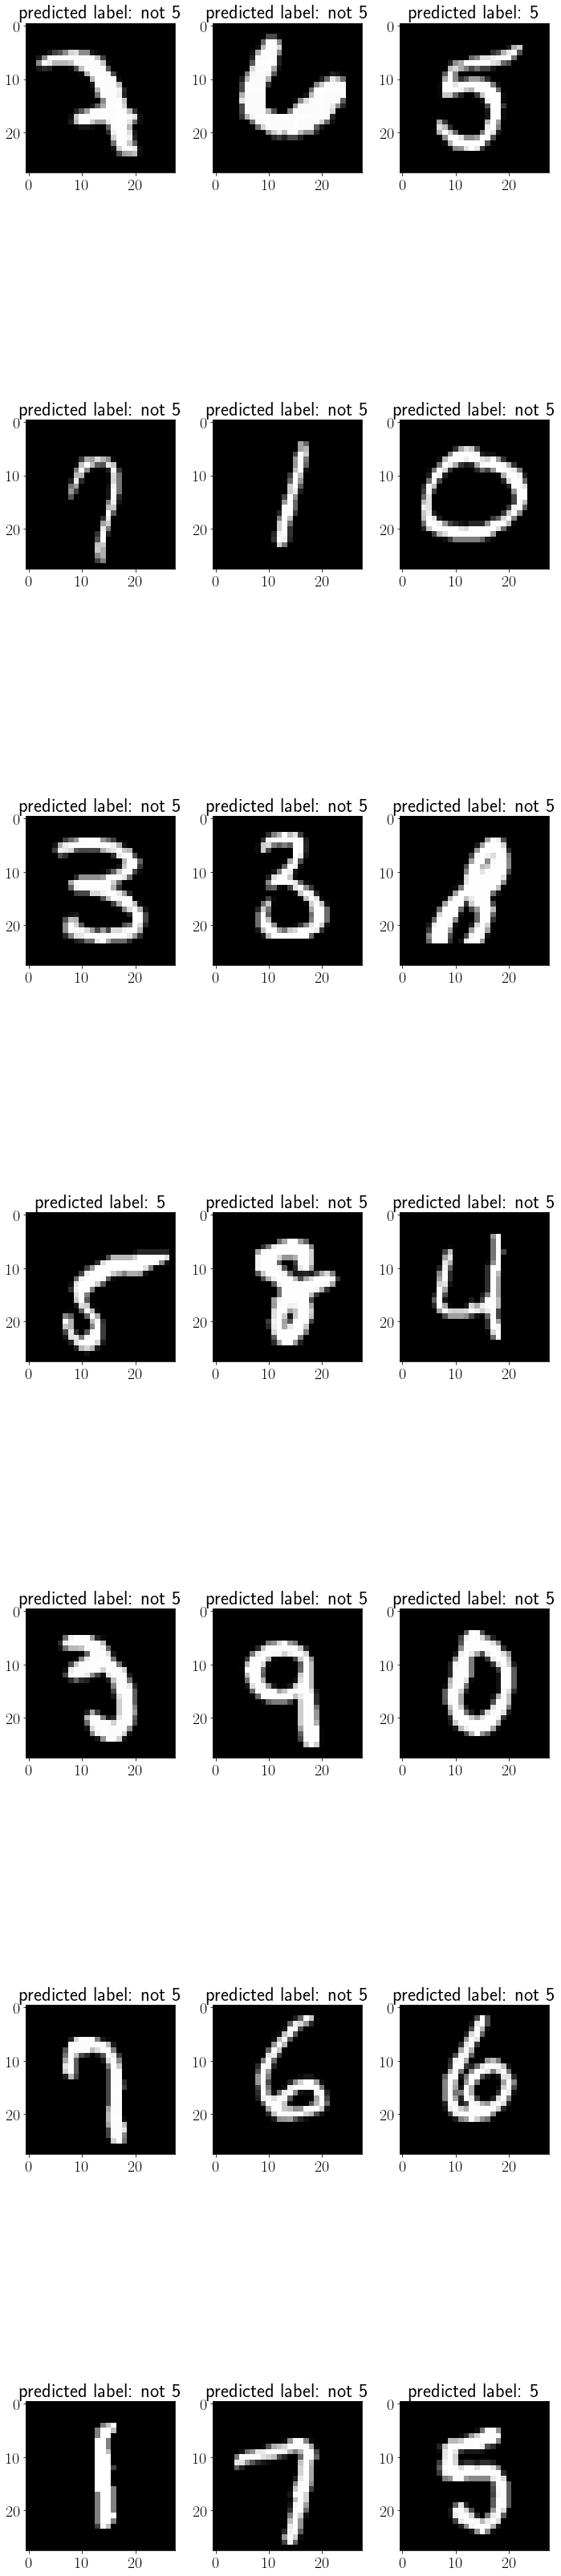

In [39]:
#a bunch of random examples
np.random.seed(0)
nrows = 7
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 50))
rand_idx = np.random.randint(0, m_test, nrows*ncols)

axes = ax.ravel()
for i in range(nrows*ncols):
    idx = rand_idx[i]
    ax = axes[i]
    x_i = np.reshape(X0_test[idx], (-1, 28))
    if y0_test_pred[idx] == 1:
        ax.set_title('predicted label: %i' %TrainingInteger)
    else:
        ax.set_title('predicted label: not %i' %TrainingInteger)
    ax.imshow(x_i, cmap='gray')
plt.tight_layout()